In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFECV

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, auc, roc_curve

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [2]:
# Using seaborn's style
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": False,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
}

plt.rcParams.update(nice_fonts)

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

width = 418.25368

## Load data

In [5]:
def get_data():
    columns = np.load("data/data_columns.npy")
    X = np.load("data/data_arousal_physio_with_pupil_for_svm_only_valid_session.npy")
    Y = np.load("data/data_arousal_label_with_pupil_for_svm_only_valid_session.npy")
    return pd.DataFrame(X, columns=columns), pd.DataFrame(Y)

In [6]:
X, Y = get_data()
#X = X.drop(["SKT_mean_abs_diff", "SKT_std"], axis=1)
print X.shape
print Y.shape

(82400, 25)
(82400, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8c7e5aa810>]],
      dtype=object)

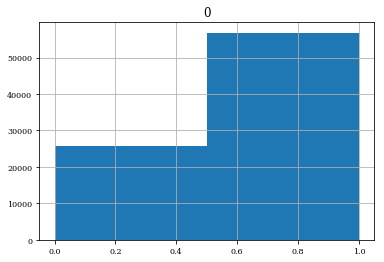

In [7]:
# binarize the problem
Y[Y<=4] = 0
Y[Y>=5] = 1
Y.hist(bins=2)

## LinearSVC

### Search for optimal C parameter

In [42]:
def create_classifier(c=1):
    lsvc = LinearSVC(C=c, tol=1e-4, dual=False, fit_intercept=False, class_weight='balanced', verbose=True)
    # evaluate using 5-fold cross validation
    #stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    stratified_cv = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=seed)
    return lsvc, stratified_cv

In [79]:
result = []

for i in range(5,-5,-1):
    c = 1*10**i
    lsvc, stratified_cv = create_classifier(c=c)
    results = cross_val_score(lsvc, X, Y.values.ravel(), cv=stratified_cv, scoring='accuracy', verbose=0)
    result.append({ "c": c, "score" : results.mean()*100, "std" : results.std()*100})

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [80]:
for r in sorted(result, key=lambda x: x["score"]):
    print "c: {:.0e} --> score: {:f}".format(r["c"], r["score"])

max_score = max(result, key=lambda x: x["score"])

print
print "optimal value: {:.0e}".format(max_score["c"])
print("Accuracy: %.2f%% (%.2f%%)" % (max_score["score"], max_score["std"]))

c: 1e-04 --> score: 58.438107
c: 1e-03 --> score: 59.228155
c: 1e-02 --> score: 59.949029
c: 1e-01 --> score: 61.536408
c: 1e+00 --> score: 62.150485
c: 1e+01 --> score: 62.220874
c: 1e+05 --> score: 62.250000
c: 1e+04 --> score: 62.250000
c: 1e+03 --> score: 62.250000
c: 1e+02 --> score: 62.250000

optimal value: 1e+05
Accuracy: 62.25% (0.42%)


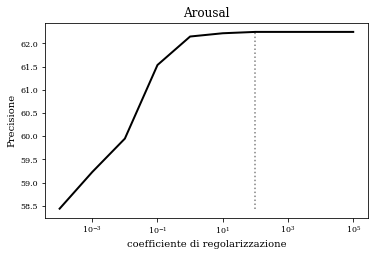

In [82]:
results = { r["c"] : r for r in result }
c_values = list(sorted(results.keys()))
scores = [ results[c]["score"] for c in c_values ]
fig = plt.figure(figsize=set_size(width=width))
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(c_values, scores, color='k', lw=2)
ax.vlines([1e2], min(scores), 62.25, colors='gray', linestyles="dotted")
ax.set_xscale('log')
ax.set_title("Arousal")
ax.set_ylabel("Precisione")
ax.set_xlabel("coefficiente di regolarizzazione")
plt.show()
fig.savefig("reg_coef_aro.pdf", format="pdf", bbox_inches='tight')

Create classifier with optimal parameter

## KBest Feature selection + SVC

In [83]:
# Such a large set of features can cause overfitting and also slow computing
# Use feature selection to select the most important features
import sklearn.feature_selection
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, auc, roc_curve

In [84]:
scores_by_kbest = []

for k in range(1,X.shape[1]+1):

    lsvc, stratified_cv = create_classifier(c=1e2) 
    kbest_selector = sklearn.feature_selection.SelectKBest(k=k)
    kbest_selector.fit(X, Y)
    
    scores_train = []
    scores_test = []
    
    for train_index, test_index in stratified_cv.split(X, Y):
        
        x_train, y_train = kbest_selector.transform(X)[train_index], Y.iloc[train_index]
        x_test, y_test = kbest_selector.transform(X)[test_index], Y.iloc[test_index]
        
        lsvc.fit(x_train, y_train)
        
        y_train_pred = lsvc.predict(x_train)
        score = balanced_accuracy_score(y_train, y_train_pred)
        scores_train.append(score)
        
        y_test_pred = lsvc.predict(x_test)
        score = balanced_accuracy_score(y_test, y_test_pred)
        scores_test.append(score)
        
        fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
        roc_auc = auc(fpr, tpr)
        
        #results = cross_val_score(lsvc, kbest_selector.transform(X), Y, scoring='balanced_accuracy', cv=stratified_cv, verbose=0)
    
    ks = {
        "feature"         : X.columns[kbest_selector.get_support()],
        "feature_pvalue"  : kbest_selector.pvalues_,
        "feature_coeff"   : lsvc.coef_,
        "score_train"     : np.array(scores_train).mean(),
        "std_train"       : np.array(scores_train).std(),
        "score_test"      : np.array(scores_test).mean(),
        "std_test"        : np.array(scores_test).std(),
        "fpr"             : fpr,
        "tpr"             : tpr,
        "roc_auc"         : roc_auc
    }
    
    scores_by_kbest.append(ks)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

In [85]:
for r in sorted(scores_by_kbest, key=lambda x: x["roc_auc"]):
    nfeature, score_train, score_test = len(r["feature"]), r["score_train"], r["score_test"]
    roc_auc = r["roc_auc"]
    print "n: {} --> score_train: {:.5f} --> score_test: {:.5f} --> roc_auc: {:.5f}".format(nfeature, score_train, score_test, roc_auc)

n: 1 --> score_train: 0.49998 --> score_test: 0.50012 --> roc_auc: 0.50011
n: 2 --> score_train: 0.50327 --> score_test: 0.50214 --> roc_auc: 0.50153
n: 3 --> score_train: 0.51018 --> score_test: 0.51055 --> roc_auc: 0.51007
n: 6 --> score_train: 0.54906 --> score_test: 0.55013 --> roc_auc: 0.54691
n: 5 --> score_train: 0.54968 --> score_test: 0.55105 --> roc_auc: 0.54873
n: 4 --> score_train: 0.56291 --> score_test: 0.56152 --> roc_auc: 0.55642
n: 7 --> score_train: 0.58107 --> score_test: 0.57790 --> roc_auc: 0.57287
n: 8 --> score_train: 0.58376 --> score_test: 0.58202 --> roc_auc: 0.57854
n: 9 --> score_train: 0.58364 --> score_test: 0.58198 --> roc_auc: 0.57862
n: 10 --> score_train: 0.59894 --> score_test: 0.59655 --> roc_auc: 0.59540
n: 19 --> score_train: 0.61138 --> score_test: 0.61017 --> roc_auc: 0.60237
n: 17 --> score_train: 0.61401 --> score_test: 0.61230 --> roc_auc: 0.60501
n: 20 --> score_train: 0.61557 --> score_test: 0.61433 --> roc_auc: 0.60539
n: 18 --> score_train

In [86]:
max_score = max(scores_by_kbest, key=lambda x: x["roc_auc"])

print("Optimal number of features : %d" % len(max_score["feature"]))
print max_score["feature"]
print max_score['feature_coeff']

print
print("roc_auc: %.2f%% (%.2f%%)" % (max_score["score_test"]*100, max_score["std_test"]*100))

Optimal number of features : 14
Index([u'ECG_mean_diff', u'EDA_mean_diff', u'Resp_std', u'Resp_min',
       u'Resp_max', u'Resp_mean_diff', u'Resp_mean_abs_diff', u'SKT_mean',
       u'SKT_std', u'SKT_min', u'SKT_max', u'SKT_mean_diff',
       u'SKT_mean_abs_diff', u'Pupil'],
      dtype='object')
[[  0.0833136    0.05639507  -0.45718477  -0.56468467  -0.21989849
   -0.04858839   0.94023729 -10.76711967  -1.15064722   3.5009735
    7.31937622   0.02609932   4.85656149   0.5230983 ]]

roc_auc: 62.07% (0.41%)


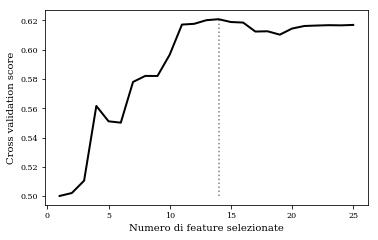

In [87]:
nfeature = [ len(s["feature"]) for s in scores_by_kbest ]
scores = [ s["score_test"] for s in scores_by_kbest ]
plt.figure(figsize=set_size(width=width))
plt.xlabel("Numero di feature selezionate")
plt.ylabel("Cross validation score")
plt.plot(nfeature, scores, color='k', lw=2)
plt.gca().vlines([len(max_score["feature"])], min(scores), max(scores), colors='gray', linestyles="dotted")
plt.show()

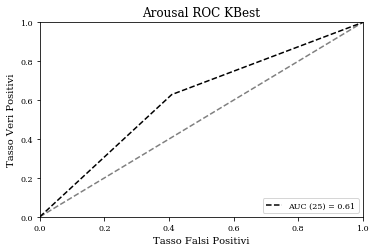

In [88]:
#from itertools import cycle
#lines = ["-","--","-.",":"]
#linecycler = cycle(lines)

fig = plt.figure(figsize=set_size(width=width))
ax = fig.add_subplot(1,1,1)
plt.title('Arousal ROC KBest')
plt.plot([0, 1], [0, 1],'--', c='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Tasso Veri Positivi')
plt.xlabel('Tasso Falsi Positivi')
for r in scores_by_kbest[24:25]:
    n = len(r["feature"])
    fpr, tpr, roc_auc = r["fpr"], r["tpr"], r["roc_auc"]
    #linestyle = next(linecycler)
    ax.plot(fpr, tpr, 'k--', label = 'AUC (%d) = %0.2f' % (n, roc_auc))

plt.legend(loc = 'lower right')      
plt.show()


## Recursive feature selection

In [104]:
lsvc, stratified_cv = create_classifier(c=1e2)
rfecv = RFECV(estimator=lsvc, step=1, cv=stratified_cv, scoring='accuracy', n_jobs=-1)

In [105]:
rfecv.fit(X, Y)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

RFECV(cv=StratifiedShuffleSplit(n_splits=5, random_state=7, test_size=0.2,
            train_size=None),
   estimator=LinearSVC(C=100.0, class_weight='balanced', dual=False, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=True),
   min_features_to_select=1, n_jobs=-1, scoring='accuracy', step=1,
   verbose=0)

In [111]:
print rfecv.n_features_
print rfecv.get_support()
print X.columns[rfecv.get_support()]
print rfecv.ranking_
print rfecv.grid_scores_

coef = rfecv.estimator_.coef_[0]**2
coef = coef / coef.sum()

print dict(zip(X.columns[rfecv.get_support()], coef))

6
[False False False False False False False False False False False False
 False False False False False False  True  True  True  True False  True
  True]
Index([u'SKT_mean', u'SKT_std', u'SKT_min', u'SKT_max', u'SKT_mean_abs_diff',
       u'Pupil'],
      dtype='object')
[ 9  4  8 12 16  3  5 10  6 17 19 11 14 13  2 18 15  7  1  1  1  1 20  1
  1]
[0.31067961 0.58484223 0.60536408 0.6298665  0.61160194 0.63376214
 0.6226699  0.61900485 0.61248786 0.61197816 0.61196602 0.6176335
 0.61663835 0.61657767 0.61622573 0.61599515 0.61603155 0.61554612
 0.61514563 0.61600728 0.62137136 0.62179612 0.62224515 0.62234223
 0.6225    ]
{'SKT_max': 0.316061577030247, 'SKT_mean': 0.5383156107254167, 'SKT_mean_abs_diff': 0.10980946476153454, 'Pupil': 0.0005949931151258122, 'SKT_std': 0.007082204872006105, 'SKT_min': 0.02813614949566971}


In [107]:
print("Optimal number of features : %d" % rfecv.n_features_)
print { X.columns[support] : rfecv.ranking_[support] for support in rfecv.get_support(indices=1) }


print
print("Accuracy: %.2f%% (%.2f%%)" % (rfecv.grid_scores_[rfecv.n_features_ - 1]*100, 0))

Optimal number of features : 6
{'SKT_max': 1, 'SKT_mean': 1, 'SKT_mean_abs_diff': 1, 'Pupil': 1, 'SKT_std': 1, 'SKT_min': 1}

Accuracy: 63.38% (0.00%)


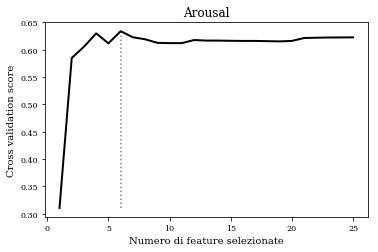

In [108]:
# Plot number of features VS. cross-validation scores
nfeature = range(1, X.shape[1]+1)
fig = plt.figure(figsize=set_size(width=width))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Arousal")
ax.set_xlabel("Numero di feature selezionate")
ax.set_ylabel("Cross validation score")
ax.plot(nfeature, rfecv.grid_scores_, color='K', lw=2)
ax.vlines([rfecv.n_features_], min(rfecv.grid_scores_), max(rfecv.grid_scores_), colors='gray', linestyles="dotted")
fig.show()
fig.savefig("rfecv_aro.pdf", format="pdf", bbox_inches='tight')

In [109]:
from sklearn.metrics import average_precision_score
# GENERATE ROC FOR RFECV
lsvc, stratified_cv = create_classifier(c=1e2) 
scores_train = []
scores_test = []
for train_index, test_index in stratified_cv.split(X, Y):

    x_train, y_train = rfecv.transform(X)[train_index], Y.iloc[train_index]
    x_test, y_test = rfecv.transform(X)[test_index], Y.iloc[test_index]

    lsvc.fit(x_train, y_train)

    y_train_pred = lsvc.predict(x_train)
    score = balanced_accuracy_score(y_train, y_train_pred)
    scores_train.append(score)

    y_test_pred = lsvc.predict(x_test)
    score = balanced_accuracy_score(y_test, y_test_pred)
    scores_test.append(score)

    fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)
    
    y_test_pred = lsvc.decision_function(x_test)
    pre_rec = average_precision_score(y_test, y_test_pred)
    
    r = {
        "feature"         : X.columns[rfecv.get_support()],
        "score_train"     : np.array(scores_train).mean(),
        "std_train"       : np.array(scores_train).std(),
        "score_test"      : np.array(scores_test).mean(),
        "std_test"        : np.array(scores_test).std(),
        "fpr"             : fpr,
        "tpr"             : tpr,
        "roc_auc"         : roc_auc,
        "pre_rec"         : pre_rec
    }

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

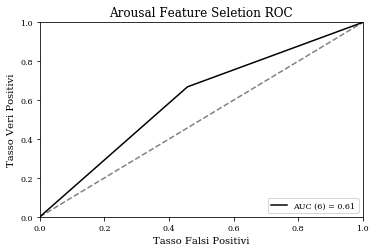

In [110]:
## PLOT ROC CURVE FOR KBEST AND RFECV

fig = plt.figure(figsize=set_size(width=width))
ax = fig.add_subplot(1,1,1)
plt.title('Arousal Feature Seletion ROC')
plt.plot([0, 1], [0, 1],'--', c='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Tasso Veri Positivi')
plt.xlabel('Tasso Falsi Positivi')

n = len(r["feature"])
fpr, tpr, roc_auc = r["fpr"], r["tpr"], r["roc_auc"]
ax.plot(fpr, tpr, 'k-', label = 'AUC (%d) = %0.2f' % (n, roc_auc))

plt.legend(loc = 'lower right')      
plt.show()